## Задание

Преоразовать существующий код для распознавания последовательности рукописных символов в текст.
Написать генератор произвольной последовательности рукописных символов.

##### ГЕНЕРАЦИЯ НАБОРА ДАННЫХ
- Сгенерировать набор текстовых строк из допустимых символов.
- Каждому набору поставить в соотвествие массив изоражений соответствующих символов.
- Добавить пробелы для разделения слов, символы пробелов не использовать во время классификации.

##### КЛАССИФИКАЦИЯ
Часть символов оставить для обучения классификатора. Остальные  классифицировать
по аналогии с примером mnist с прошлого занятия. Т.е. преобразовывать изображение в вектор.
- Использовать метод k ближайших соседей.
- Выбрать оптимальный классификатор. Варьировать только k - количество соседей.
- Метрика для измерения точности классификации, и выбора оптимального классификатора относительно параметра k - accuracy.

##### РАСПОЗНАВАНИЕ
- Итак, к данному этапу Вы из массива изображений "восстановили" текст.
- Случайно удалите некоторые символы,и случайно добавьте символы в результат распознавания.
- Рассчитайте метрику CER.

## Решение

##### Импорты

In [58]:
import random, os, pickle, lzma, time, editdistance

import cv2

import matplotlib.pyplot as plt
import numpy as np

from concurrent.futures import ThreadPoolExecutor

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import pandas as pd

##### Настройки

In [59]:
# Зерно
RANDOM_SEED = 42

# Папка лабораторной
LAB_DIR = 'Lab3'

# Папка с символами
DATA_DIR = 'data'

# Папка с изображениями слов
WORD_DIR = 'words' 

# Файл модели
PICKLE_FILE = 'lab3_model.pkl.xz'

# Размер изображений для преобразования
IMAGE_SIZE = 32

# Количество слов
WORD_COUNT = 10

# Минимальная длина слова
WORD_LENGTH_MIN = 8

# Максимальная длина слова
WORD_LENGTH_MAX = 12

# Число замен
WORD_ADDITION_MIN = 0
WORD_ADDITION_MAX = 3
WORD_REMOVAL_MIN = 0
WORD_REMOVAL_MAX = 3

##### Настройки KNN

In [60]:
K_MIN = 1
K_MAX = 5

##### Инициализация генератора случайных чисел

In [61]:
rnd = random.Random(RANDOM_SEED)

##### Функция загрузки изображения

In [62]:
# Функция обрезки изображения
def crop_image(image, mask, pixel_value=255):
    crop_mask = ~np.all(mask == pixel_value, axis=1)

    return image[crop_mask, :][:,  ~np.all(mask[crop_mask, :] == pixel_value, axis=0)]

In [63]:
def preprocess_image(img, size=IMAGE_SIZE):
    _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)

    img = crop_image(img, thresh, pixel_value=0)

    if size > 0:
        img = cv2.resize(img, (size, size)) 

    return img

In [64]:
# Функция загрузки изображения
def load_image(path, preprocess=True, size=IMAGE_SIZE):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    if preprocess:
        img = preprocess_image(img, size=size)

    return img

##### Функция генерации изображения "слова"

In [65]:
def generate_word_image(word, image_paths, width_diapason=(0.9, 1.1), height_diapason=(0.9, 1.1), spacing_diapason=(10, 20), vertical_spread=50, padding=(5, 5, 5, 5)):
    images = [
            { "image": cv2.resize(cv2.imread(path), (0, 0), fx=width, fy=height), "spacing": spacing }
            for path, width, height, spacing
            in zip(
                image_paths, 
                [rnd.uniform(width_diapason[0], width_diapason[1]) for i in range(len(image_paths))], 
                [rnd.uniform(height_diapason[0], height_diapason[1]) for i in range(len(image_paths))],
                [rnd.randint(spacing_diapason[0], spacing_diapason[1]) for i in range(len(image_paths))]
                )
        ]

    images[-1]['spacing'] = 0

    img_width = sum([img_entry['image'].shape[1] + img_entry['spacing'] for img_entry in images])
    img_height = max([img_entry['image'].shape[0] for img_entry in images]) + vertical_spread

    word_image = np.full((img_height + padding[1] + padding[3], img_width + padding[0] + padding[2], 3), 255)

    x_offset = padding[0]

    for img_entry in images:
        y_offset = padding[1] + rnd.randint(0, img_height - img_entry['image'].shape[0])

        word_image[y_offset:y_offset + img_entry['image'].shape[0], x_offset:x_offset + img_entry['image'].shape[1]] = img_entry['image']

        x_offset += img_entry['image'].shape[1] + img_entry['spacing']

    return word_image

##### Функция кодирования слова
Для каждой буквы получает её индекс в массиве классов и преобразует её в соотвествующую букву англ. алфавита.

'(' -> 0 -> a, ')' -> 1 -> b, ...

In [66]:
ENCODE_START = ord('a')

def encode_word(word, classes):
    return ''.join(chr(ENCODE_START + classes.index(char)) for char in word)

def decode_word(encword, classes):
    return ''.join(classes[ord(encchar) - ENCODE_START] for encchar in encword)

##### Функция нахождения CER

In [67]:
def CER(text, text_pred):
    return editdistance.eval(text, text_pred) / len(text) if len(text) > 0 else 0

### 1. ГЕНЕРАЦИЯ НАБОРА ДАННЫХ

##### Список классов

In [68]:
class_dirs = {it.name.replace('times', '*'): it.name for it in os.scandir('\\'.join([LAB_DIR, DATA_DIR])) if it.is_dir()}
classes = list(class_dirs.keys())

print(f'Символы [{len(classes)}]:', *classes)

Символы [21]: ( ) + , - 0 1 2 3 4 5 6 7 8 9 h t * w X y


##### Генерация слов

In [69]:
words = [''.join(rnd.choices(classes, k=rnd.randint(WORD_LENGTH_MIN, WORD_LENGTH_MAX))) for i in range(WORD_COUNT)]

print('Слова:')

for word in words:
    print(' ', word)

Слова:
  (0-h9w)3
  )-76h934
  t(t92,y2)+
  7th6y26*7w
  -)8ty*w24*,2
  99)86040X9
  9*t-(10-X
  -5w8,+h6h3
  3-y5)(+8t3)3
  6yw(h9608+4


##### Загрузка списка изображений

In [70]:
# Словарь с путями до слов
image_paths = {char: [it.path for it in os.scandir('\\'.join([LAB_DIR, DATA_DIR, class_dirs[char]])) if it.is_file()] for char in classes}

##### Присвоение "словам" списка изображений

In [71]:
word_image_paths = [[rnd.choice(image_paths[char]) for char in word] for word in words]

Слово: (0-h9w)3


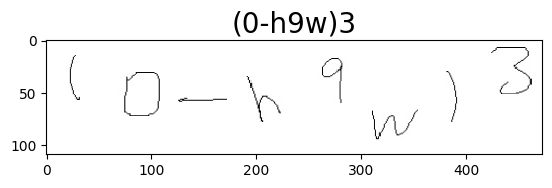

Слово: )-76h934


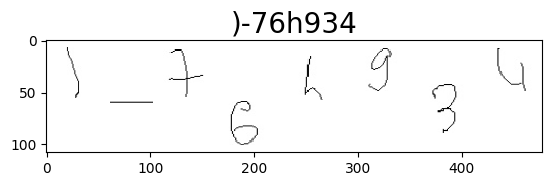

Слово: t(t92,y2)+


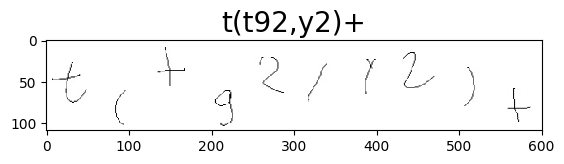

Слово: 7th6y26*7w


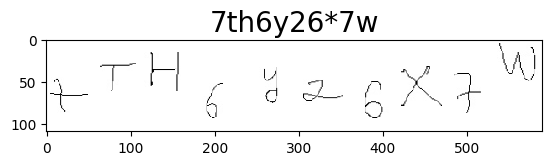

Слово: -)8ty*w24*,2


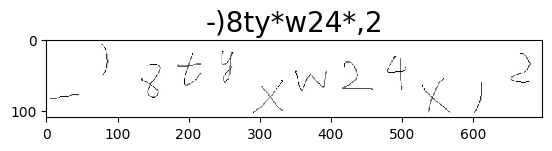

Слово: 99)86040X9


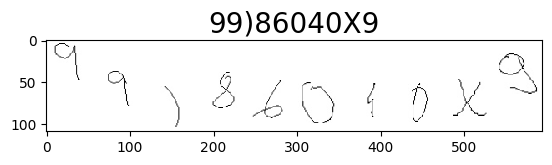

Слово: 9*t-(10-X


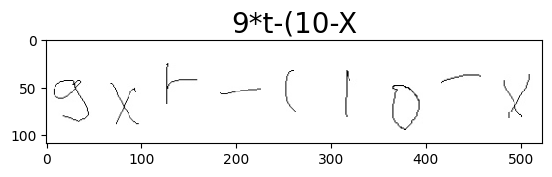

Слово: -5w8,+h6h3


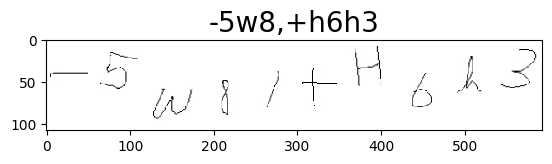

Слово: 3-y5)(+8t3)3


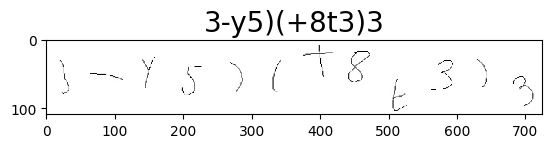

Слово: 6yw(h9608+4


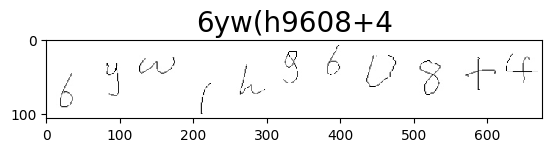

In [72]:
for i, word, imglist in zip(range(len(words)), words, word_image_paths):
    print('Слово:', word)

    img = generate_word_image(word, imglist)

    cv2.imwrite('\\'.join([LAB_DIR, WORD_DIR, f'{i}_{encode_word(word, classes)}.png']), img)

    plt.imshow(img, interpolation="nearest")
    plt.title(word, fontsize=20)

    plt.show()

### 2. КЛАССИФИКАЦИЯ

##### Загружаем изображения

In [73]:
with ThreadPoolExecutor() as executor:
    data = np.concatenate(list(executor.map(lambda x: [np.append(load_image(path).flatten(), x[0]) for path in image_paths[x[1]]], enumerate(classes))))

In [74]:
# IMG_SIZE * IMG_SIZE + 1 (класс)
data.shape

(225291, 1025)

##### Разделяем на массивы признаков и классов

In [75]:
X, y = np.split(data, [data.shape[1] - 1], axis=1)

y = y.flatten()

In [76]:
X.shape

(225291, 1024)

In [77]:
y.shape

(225291,)

##### Разделяем на обучающую и тестовую выборки

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = RANDOM_SEED)

##### Ищем оптимальный k методом кросс валидации

In [45]:
param_grid = { 'n_neighbors': list(range(K_MIN, K_MAX + 1)) }

print(param_grid)

grid_start_time = time.time()

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='accuracy', verbose=3)
grid_search.fit(X_train, y_train)

grid_time = time.time() - grid_start_time

print('Выбранное k:', grid_search.best_params_['n_neighbors'])

best_n_neighbors = grid_search.best_params_['n_neighbors']

if grid_time >= 60:
    print(f'Затраченное время: {grid_time / 60:.1f} мин.')
else:
    print(f'Затраченное время: {grid_time:.1f} сек.')

{'n_neighbors': [1, 2, 3, 4, 5]}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .....................n_neighbors=1;, score=0.966 total time= 1.4min
[CV 2/5] END .....................n_neighbors=1;, score=0.971 total time= 1.4min
[CV 3/5] END .....................n_neighbors=1;, score=0.970 total time= 1.4min
[CV 4/5] END .....................n_neighbors=1;, score=0.966 total time= 1.4min
[CV 5/5] END .....................n_neighbors=1;, score=0.968 total time= 1.4min
[CV 1/5] END .....................n_neighbors=2;, score=0.910 total time= 1.5min
[CV 2/5] END .....................n_neighbors=2;, score=0.914 total time= 1.4min
[CV 3/5] END .....................n_neighbors=2;, score=0.912 total time= 1.6min
[CV 4/5] END .....................n_neighbors=2;, score=0.912 total time= 1.5min
[CV 5/5] END .....................n_neighbors=2;, score=0.914 total time= 1.4min
[CV 1/5] END .....................n_neighbors=3;, score=0.906 total time= 1.5min
[CV 2/5] END ...

##### Обучаем модель

In [46]:
knn_start_time = time.time()

knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

knn_time = time.time() - knn_start_time

print('Точность: ', accuracy_score(y_test, y_pred))

if knn_time >= 60:
    print(f'Затраченное время: {knn_time / 60:.1f} мин.')
else:
    print(f'Затраченное время: {knn_time:.1f} сек.')

Точность:  0.9810246679316889
Затраченное время: 5.8 мин.


##### Сохраняем модель

In [47]:
with lzma.open('\\'.join([LAB_DIR, PICKLE_FILE]), 'wb') as model_file:
    pickle.dump(knn, model_file)

### 3. РАСПОЗНАВАНИЕ

##### Загрузка модели

In [79]:
with lzma.open('\\'.join([LAB_DIR, PICKLE_FILE]), 'rb') as model_file:
    knn = pickle.load(model_file)

##### Загрузка и распознавание слов

In [80]:
# Словарь с изображениями слов
words_images = {decode_word(file.name.split('_')[1].split('.')[0], classes): cv2.imread(file.path) for file in os.scandir('\\'.join([LAB_DIR, WORD_DIR])) if file.is_file()}

In [81]:
def dist(p1, p2):
    return ((p2[0] - p1[0]) ** 2 +  (p2[1] - p1[1]) ** 2) ** 0.5

def rect_distance(rect1, rect2):
    x1, y1, x1b, y1b = rect1
    x2, y2, x2b, y2b = rect2

    left = x2b < x1
    right = x1b < x2
    bottom = y2b < y1
    top = y1b < y2
    if top and left:
        return dist((x1, y1b), (x2b, y2))
    elif left and bottom:
        return dist((x1, y1), (x2b, y2b))
    elif bottom and right:
        return dist((x1b, y1), (x2, y2b))
    elif right and top:
        return dist((x1b, y1b), (x2, y2))
    elif left:
        return x1 - x2b
    elif right:
        return x2 - x1b
    elif bottom:
        return y1 - y2b
    elif top:
        return y2 - y1b
    else:             # rectangles intersect
        return 0.

Слово: (0-h9w)3


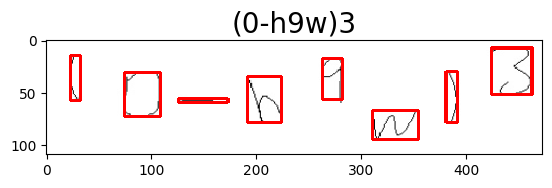

Слово: )-76h934


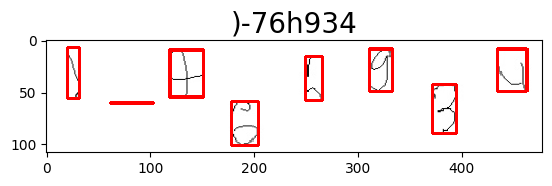

Слово: t(t92,y2)+


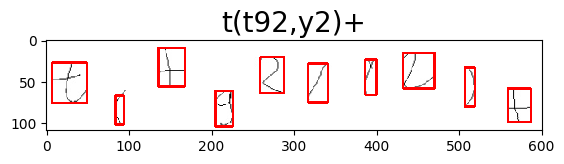

Слово: 7th6y26*7w


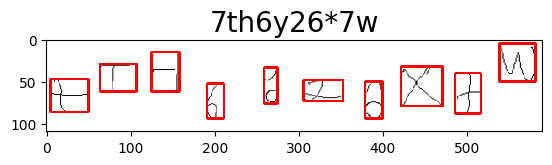

Слово: -)8ty*w24*,2


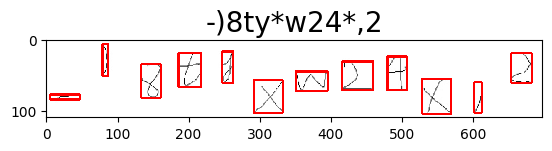

Слово: 99)86040X9


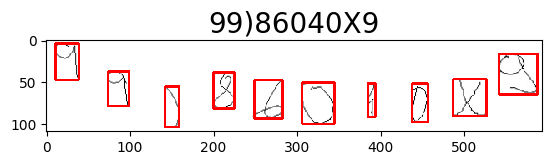

Слово: 9*t-(10-X


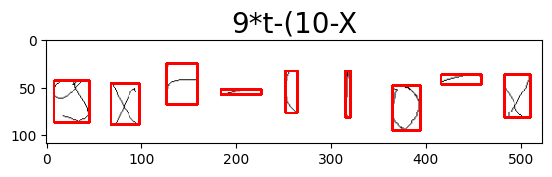

Слово: -5w8,+h6h3


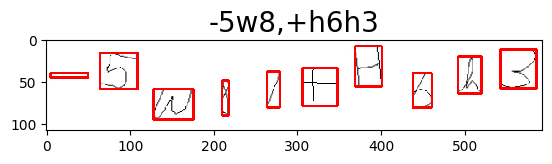

Слово: 3-y5)(+8t3)3


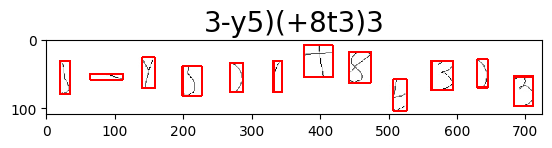

Слово: 6yw(h9608+4


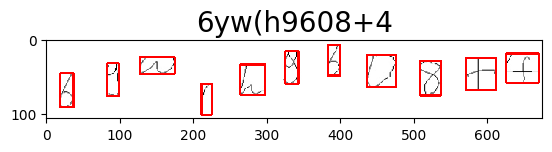

,Слово,Распознанное слово,Точность,CER
0,(0-h9w)3,(0-h9w)3,1.000000,0.000000
1,)-76h934,)-76h934,1.000000,0.000000
2,"t(t92,y2)+","+(+92,y2)+",0.800000,0.200000
3,7th6y26*7w,7th6y26*7w,1.000000,0.000000
4,"-)8ty*w24*,2","-)8ty*w24*,2",1.000000,0.000000
5,99)86040X9,"19)8,040X9",0.800000,0.200000
6,9*t-(10-X,"9*t-(10-,",0.888889,0.111111
7,"-5w8,+h6h3","-5w8,+h6h3",1.000000,0.000000
8,3-y5)(+8t3)3,3-y5)(+5t3)3,0.916667,0.083333
9,6yw(h9608+4,(yw(h3(08+4,0.727273,0.272727


In [83]:
MERGE_TRESHOLD = 10

results = []

for word, img in words_images.items():
    print('Слово:', word)

    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    img_show = img.copy()

    _, thresh = cv2.threshold(img_gray, 127, 255, 0)

    dilated = cv2.dilate(thresh, np.ones((5, 5), np.uint8))

    contours, _ = cv2.findContours(255 - thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    rects = []

    for cnt in contours:
        x1, y1, w1, h1 = cv2.boundingRect(cnt)

        rects.append((x1, y1, x1 + w1, y1 + h1))

    any_merged = True

    # Объединяем находящиеся близко контуры
    while any_merged:
        any_merged = False

        contour_merged_list = []

        for cnt1 in rects:
            merged = False

            for j in range(len(contour_merged_list)):
                cnt2 = contour_merged_list[j]

                if rect_distance(cnt1, cnt2) <= MERGE_TRESHOLD:
                    merged = True
                    any_merged = True
                    
                    mx1 = min(cnt1[0], cnt2[0])
                    my1 = min(cnt1[1], cnt2[1])
                    mx2 = max(cnt1[2], cnt2[2])
                    my2 = max(cnt1[3], cnt2[3])

                    contour_merged_list[j] = (mx1, my1, mx2, my2)

                    break

                if merged:
                    break

            if not merged:
                contour_merged_list.append(cnt1)
        
        rects = contour_merged_list

    rects.sort()

    letters = []

    for x1, y1, x2, y2 in rects:
        cv2.rectangle(img_show, (x1, y1), (x2, y2), (255, 0, 0), 2)

        letters.append(preprocess_image(img_gray[y1:y2, x1:x2]).flatten())

    plt.imshow(img_show, interpolation="nearest")
    plt.title(word, fontsize=20)

    plt.show()

    recog = [classes[i] for i in knn.predict(letters)]
    recog_word = ''.join(recog)
    
    results.append((word, recog_word, accuracy_score(list(word), recog), CER(word, recog_word)))

df_results = pd.DataFrame(results, columns=['Слово', 'Распознанное слово', 'Точность', 'CER'])

df_results

##### Замена символов

In [99]:
results_modified = []

for word, word_predicted, _, _ in results:
    num_additions = rnd.randint(WORD_ADDITION_MIN, WORD_ADDITION_MAX)
    num_removals = min(rnd.randint(WORD_REMOVAL_MIN, WORD_REMOVAL_MAX), len(word_predicted) - num_removals)

    indices = rnd.sample(range(len(word_predicted)), num_removals)
    word_predicted_with_removal = ''.join([char for i, char in enumerate(word_predicted) if i not in indices])

    indices_insert = rnd.sample(range(len(word_predicted_with_removal)), num_additions)
    characters_insert = rnd.choices(classes, k=num_additions)

    insertions = {i: c for i, c in zip(indices_insert, characters_insert)}

    word_predicted_modified = ''

    for i, c in enumerate(word_predicted_with_removal):
        if i in insertions:
            word_predicted_modified += insertions[i]

        word_predicted_modified += c

    cer = CER(word, word_predicted_modified)

    results_modified.append((word, word_predicted_modified, cer))

df_results_cer = pd.DataFrame(results_modified, columns=['Слово', 'Распознанное слово', 'CER'])

df_results_cer

,Слово,Распознанное слово,CER
0,(0-h9w)3,+(5h)9w),0.625000
1,)-76h934,)-6h934,0.125000
2,"t(t92,y2)+","+3(+692,y2)+",0.400000
3,7th6y26*7w,7th62677,0.300000
4,"-)8ty*w24*,2","8-0)8)ty*w24,",0.416667
5,99)86040X9,"1,9)8,0409",0.400000
6,9*t-(10-X,"*9t4-190,",0.777778
7,"-5w8,+h6h3","-85wX8,+6h3",0.300000
8,3-y5)(+8t3)3,",3-y5)(+5t3)3",0.166667
9,6yw(h9608+4,(w(hX3(89+4,0.545455
